In [1]:
from htke.load_data import *
from htke.process_ir_data import *
from htke.load_conditions import *
from htke.spka import *
from htke.rpka import *
pd.options.mode.chained_assignment = None  # default='warn' stops the slice error

### Go to directory

In [3]:
%pwd
%cd ir_data/GL-06-47

C:\Users\Paul Dingwall\Documents\github\htke\ir_data\GL-06-47


### Load Raw Data

<AxesSubplot:xlabel='Relative Time'>

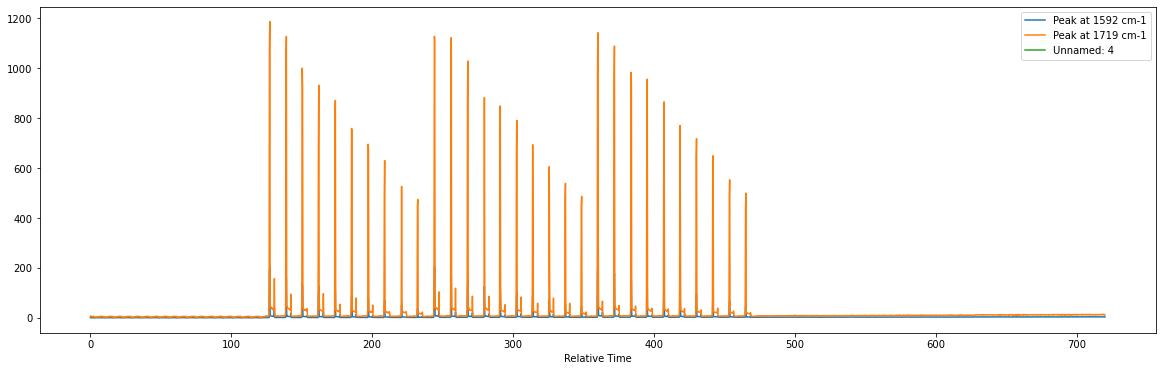

In [4]:
# Instantiate class
Data()

# Load data to dataframe
ir_data = Data.read()

# Visualise the data
Data.plot(ir_data)

#ir_data

### Find the Peaks in the Raw Data

In [5]:
# List all the wavelengths observed
print([col for col in ir_data.columns if 'Peak' in col])

['Peak at 1592 cm-1', 'Peak at 1719 cm-1']


In [6]:
# Choose peak
peak_of_interest = 'Peak at 1592 cm-1'

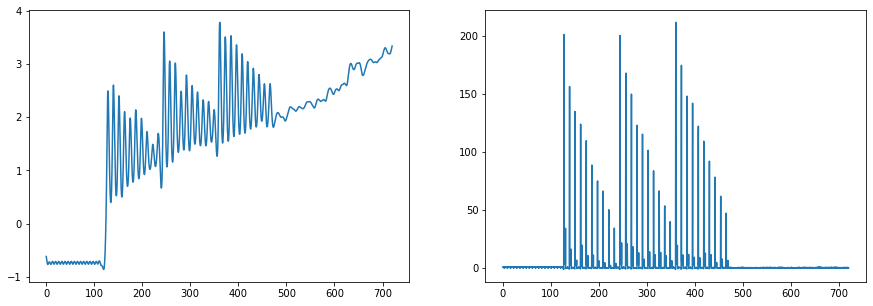

In [7]:
# Correct Baseline (needed if using area data)
correction = Data.baseline_correction(ir_data[peak_of_interest], peak_of_interest)
ir_data[peak_of_interest] = ir_data[peak_of_interest] - correction

# Plot it to see
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(ir_data['Relative Time'], correction)
ax2.plot(ir_data['Relative Time'], ir_data['Peak at 1592 cm-1'])

In [8]:
# Instantiate class
peaks = Peaks(ir_data)

# Auto find prominence and height to match number of conditions
prominence, no_reactions = peaks.auto_prom(peak_of_interest)
height = peaks.auto_height(peak_of_interest)
residence_time = peaks.auto_area(peak_of_interest, prominence, no_reactions, 10)

print('There are', no_reactions, 'reactions')
print('Prominence threshold =', np.round(prominence, 4))
print('Height threshold =', np.round(height, 4))
print('Residence time =', np.round(residence_time, 2))

There are 3 reactions
Prominence threshold = 18.3892
Height threshold = 0.9679
Residence time = 9.69


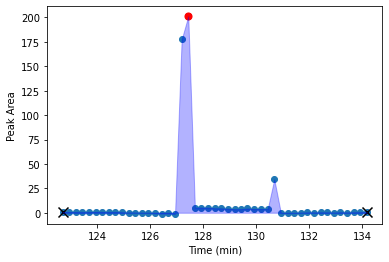

0


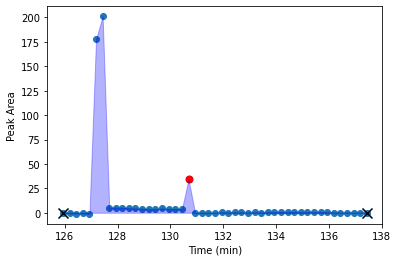

1


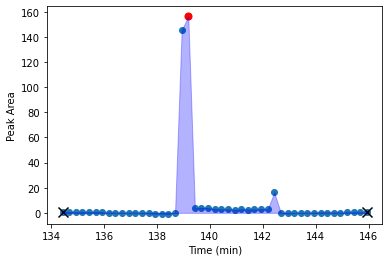

2


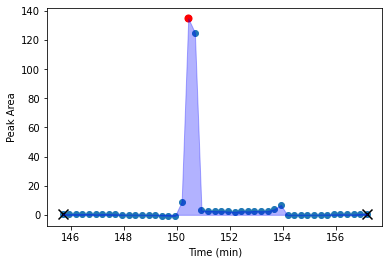

3


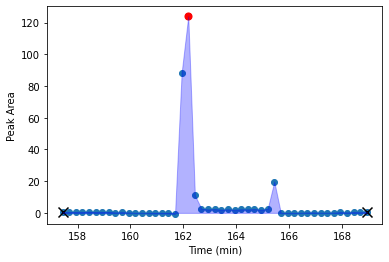

4


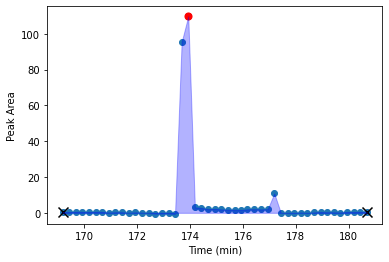

5


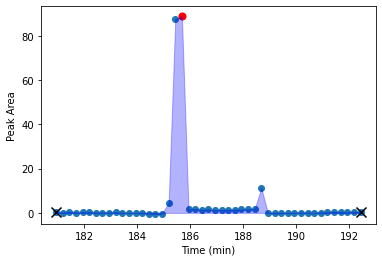

6


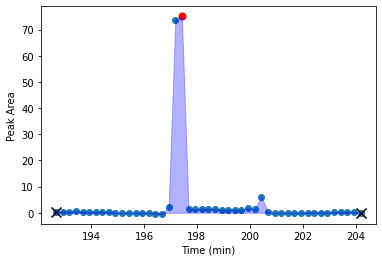

7


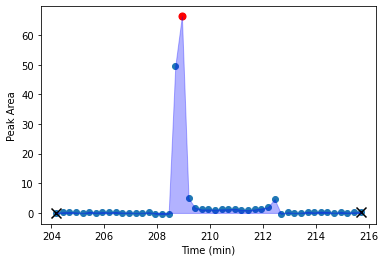

8


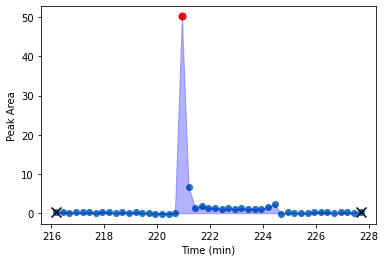

9


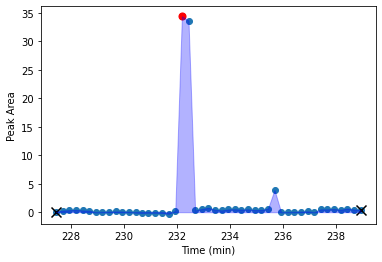

10


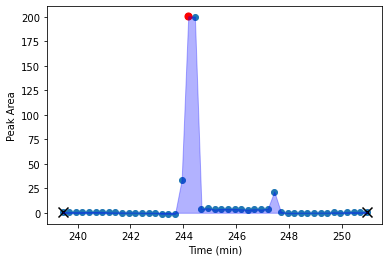

11


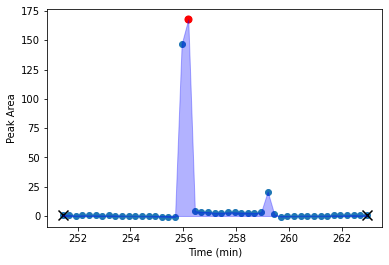

12


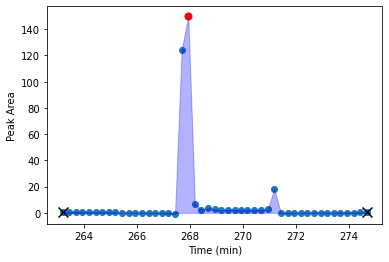

13


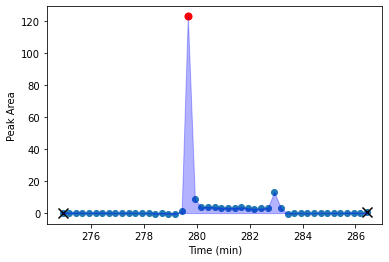

14


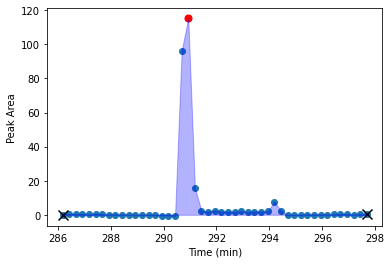

15


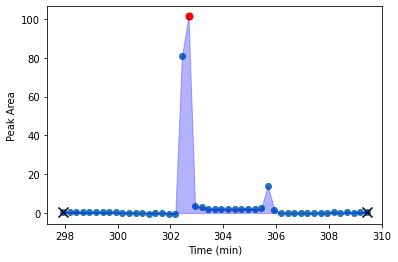

16


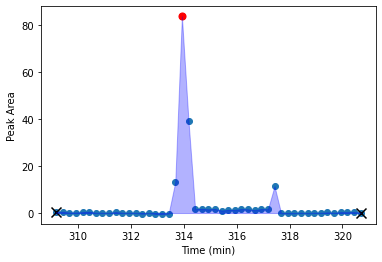

17


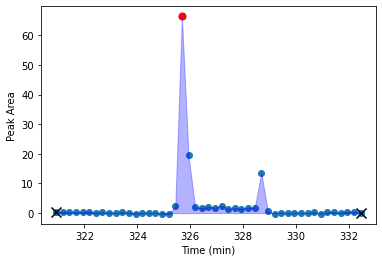

18


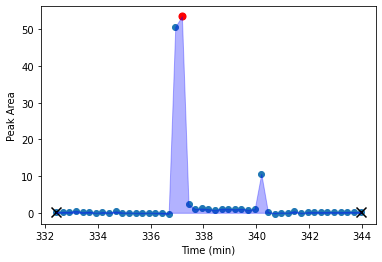

19


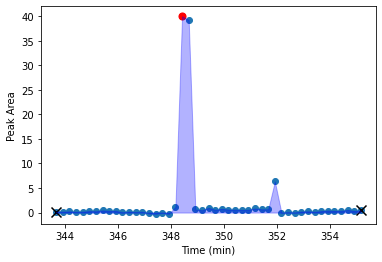

20


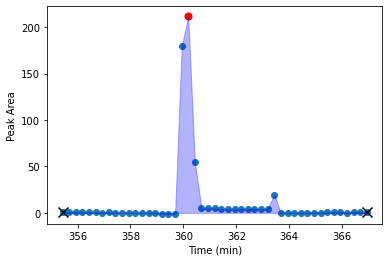

21


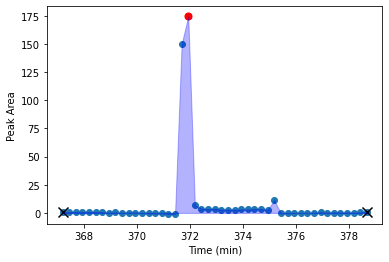

22


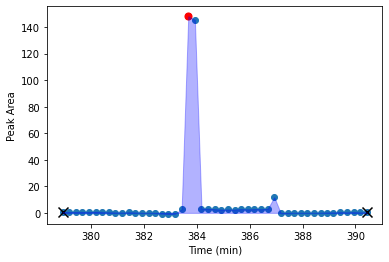

23


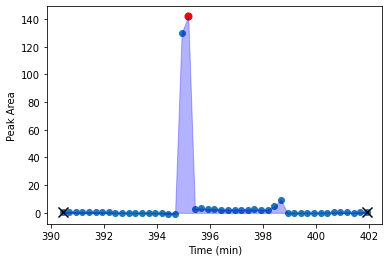

24


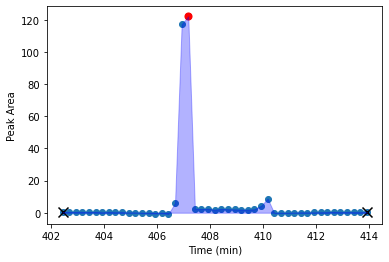

25


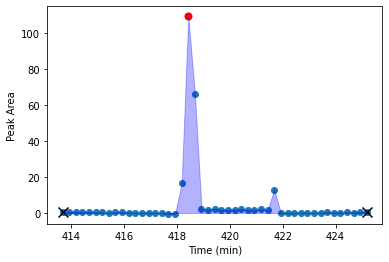

26


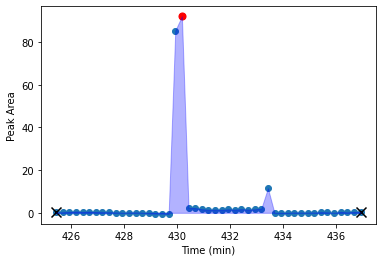

27


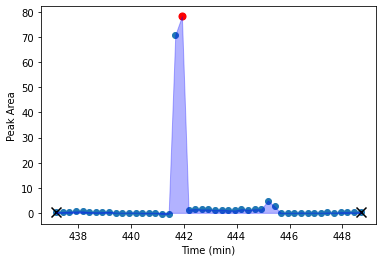

28


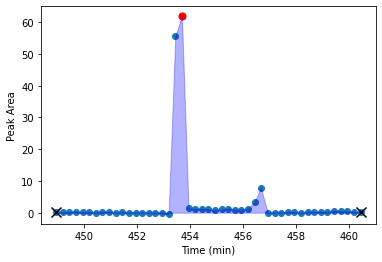

29


In [20]:
# Set some variables
points_per_reaction = 10
time_adjust_before = 0
time_adjust_after = 2

# For loop to see all areas
for var in range(0, no_reactions * points_per_reaction):
    peaks.exp_area_sp(prominence, residence_time, peak_of_interest, time_adjust_before, time_adjust_after, var)
    print(var)

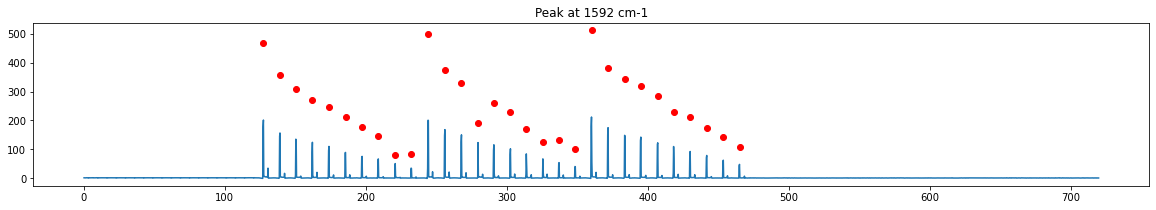

In [34]:
prominence = 32
## PROMINENCE ALL WAVELENGTHS: Determine the peak prominences of every wavelength
#processed_ir_data = peaks.prominence_all(prominence)

## PROMINENCE: Determine the peak prominences of a single wavelength
#processed_ir_data = peaks.prominence(prominence, peak_of_interest)

## HEIGHT: # Determine the peak heights of a single wavelength
#processed_ir_data = peaks.height(height, peak_of_interest)

## EXP AREA: Determine the experimental areas of a single wavelength
processed_ir_data = peaks.exp_area(prominence, residence_time, peak_of_interest, time_adjust_before, time_adjust_after)

## FITTED AREA: Determine the fitted areas of a single wavelength
#processed_ir_data = peaks.fitted_area(prominence, residence_time, peak_of_interest, time_adjust_before, time_adjust_after)

## Visualise which peaks have been picked - single peak
peaks.plot(processed_ir_data, peak_of_interest)

## Compare prominence, height, experimental area, and fitted area
#r2, compare = peaks.compare_no_height(prominence, residence_time, peak_of_interest, no_reactions, points_per_reaction, time_adjust_before, time_adjust_after)
# NOTE: Areas seem to give the best value when the starting point is exactly on the peak (no baseline before)

#processed_ir_data
#r2

### Smooth the data

#### Average t0s

In [35]:
processed_ir_data = peaks.t0_correction(processed_ir_data, no_reactions, points_per_reaction)

#### Apply linear smoothing

In [36]:
processed_ir_data = peaks.linear_correction(processed_ir_data, no_reactions, points_per_reaction)

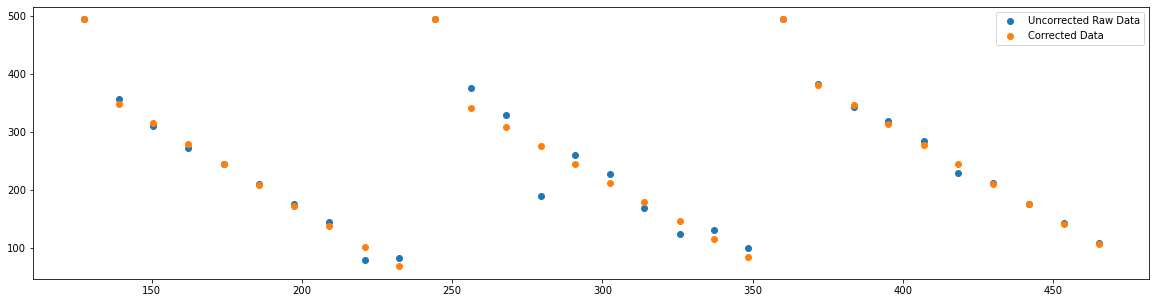

In [37]:
plt.figure(figsize=(20,5))
plt.scatter(processed_ir_data['Relative Time'], processed_ir_data['Raw Peak Property'], label = 'Uncorrected Raw Data')
plt.scatter(processed_ir_data['Relative Time'], processed_ir_data['Peak Property'], label = 'Corrected Data')
plt.legend()
plt.show()

# Read experimental conditions and add to dataframe

In [38]:
Conditions()
experimental_data = Conditions.read(processed_ir_data)
#experimental_data

Inputs seem good: IR Datapoints =  30 , Number of conditions =  30


### Create the SPKA profiles

In [39]:
spka = SPKA(experimental_data)

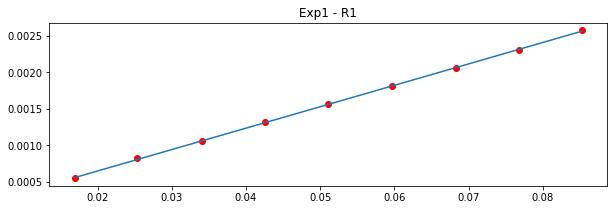

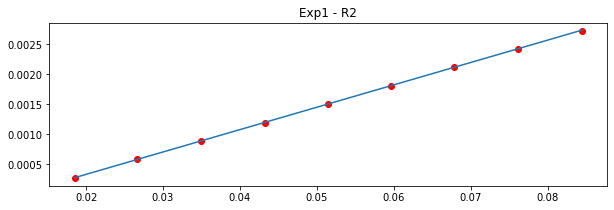

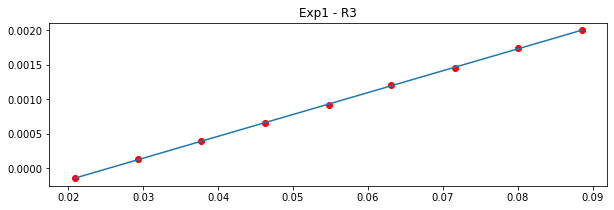

In [40]:
spka_data = spka.spka('[A]0')
#spka_data
spka.plot(spka_data)

## To Compare - must use Conditions.read(compare)
#r2 = spka.compare('[A]0')
#r2

### Perform RPKA

In [16]:
rpka = RPKA(spka_data)

KeyError: '[Raw Peak Propert]'

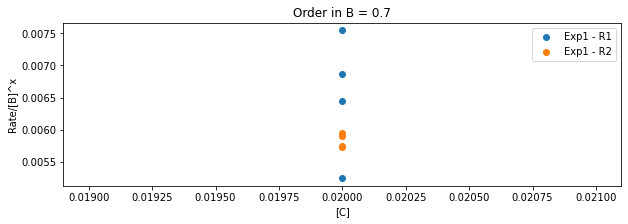

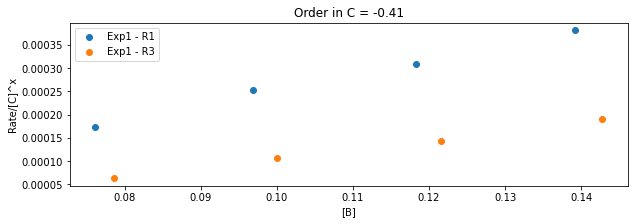

In [17]:
rpka_data = rpka.diff_excess()
#rpka_data

In [41]:
# Set up excelwriter
writer = pd.ExcelWriter(ir_data['Exp No'][0] + ' - ' +   # Adds experiment title - name of txt file
                        peak_of_interest[8:12] + ' - ' + # Adds the peak
                        processed_ir_data['Method'][0] + # Adds the methods used (prominence, area, etc)
                        '.xlsx', engine='xlsxwriter')
workbook=writer.book

# Output data
#rpka_data.to_excel(writer, sheet_name='RPKA Data', startrow=0 , startcol=0, index=False)
spka_data.to_excel(writer, sheet_name='SPKA Data', startrow=0 , startcol=0, index=False)
ir_data.to_excel(writer, sheet_name='IR Data', startrow=0 , startcol=0, index=False)
processed_ir_data.to_excel(writer, sheet_name='Processed IR', startrow=0 , startcol=0, index=False)
experimental_data.to_excel(writer, sheet_name='Experimental Data', startrow=0 , startcol=0, index=False)
#conditions.to_excel(writer, sheet_name='Conditions', startrow=0 , startcol=0, index=False)

# Save
writer.save()

# This won't work if the excel file is open